In [16]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from pandas.api.types import CategoricalDtype

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)

In [2]:
finaldf = pd.read_csv('/Users/Julia/Documents/bootcamp/DC_capstone/finaldf.csv', low_memory=False)
finaldf.head()

,PRICE,SALE_DATE,SALE_NUM,QUALIFIED,QUADRANT,WARD,SQUARE,NBHD,SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,ZIPCODE,LATITUDE,LONGITUDE,STYLE,STRUCT,USECODE,UNITS,STORIES,GRADE,CNDTN,LANDAREA,GBA,GBA_LIVING,YR_ORIGIN,YR_EXT,YR_RMDL,ROOMS,BEDRMS,BATHRMS,KITCHENS,HEAT,AC,FIREPLACES,ROOF,INTWALL,EXTWALL
0,1095000.0,2003-11-25 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914680,-77.040832,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Good,1680.0,2522.0,700.0,1910.0,1972.0,1988.0,8.0,4.0,4.0,2.0,Warm Cool,Y,5.0,Metal- Sms,Hardwood,Common Brick
1,2100000.0,2016-06-21 00:00:00,3.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914684,-77.040678,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Very Good,1680.0,2522.0,700.0,1910.0,1984.0,2009.0,9.0,5.0,3.5,2.0,Hot Water Rad,Y,4.0,Built Up,Hardwood,Common Brick
2,1602000.0,2006-07-12 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914683,-77.040629,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Good,1680.0,2484.0,700.0,1900.0,1984.0,2003.0,8.0,5.0,3.5,2.0,Hot Water Rad,Y,3.0,Built Up,Hardwood,Common Brick
3,1950000.0,2010-02-26 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914331,-77.039715,4 Story,Row Inside,11.0,1.0,4.0,Very Good,Good,2196.0,5344.0,700.0,1913.0,1972.0,2007.0,10.0,5.0,4.0,1.0,Hot Water Rad,Y,4.0,Built Up,Hardwood,Common Brick
4,1050000.0,2011-09-29 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2005,20009.0,38.915408,-77.040129,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Average,1627.0,2401.0,700.0,1906.0,1972.0,2011.0,8.0,4.0,3.5,2.0,Hot Water Rad,Y,1.0,Metal- Sms,Hardwood,Common Brick


In [3]:
# MODIFICATIONS

#new dataframe with timestamp instead of datetime for SALE_DATE
finaldf.SALE_DATE = pd.to_datetime(finaldf.SALE_DATE)

times = []
for i in finaldf['SALE_DATE']:
    times.append(datetime.timestamp(i))
finaldf['SALE_DATE'] = times
    
#dropping LATITUDE and LONGITUDE because these values zig-zag between properties.
#dropping CENSUS_TRACT because it's included in CENSUS_BLOCK.
dropdf = finaldf.drop(['LATITUDE', 'LONGITUDE', 'CENSUS_TRACT'], axis=1)

#remove spaces
strips=dropdf['CENSUS_BLOCK'].apply(str).str.replace(" ", "")
dropdf['CENSUS_BLOCK'] = strips

#change numerical to categorical
for col in ['SALE_NUM', 'SQUARE', 'CENSUS_BLOCK', 'USECODE', 'ZIPCODE']:
    dropdf[col] = dropdf[col].astype('category')


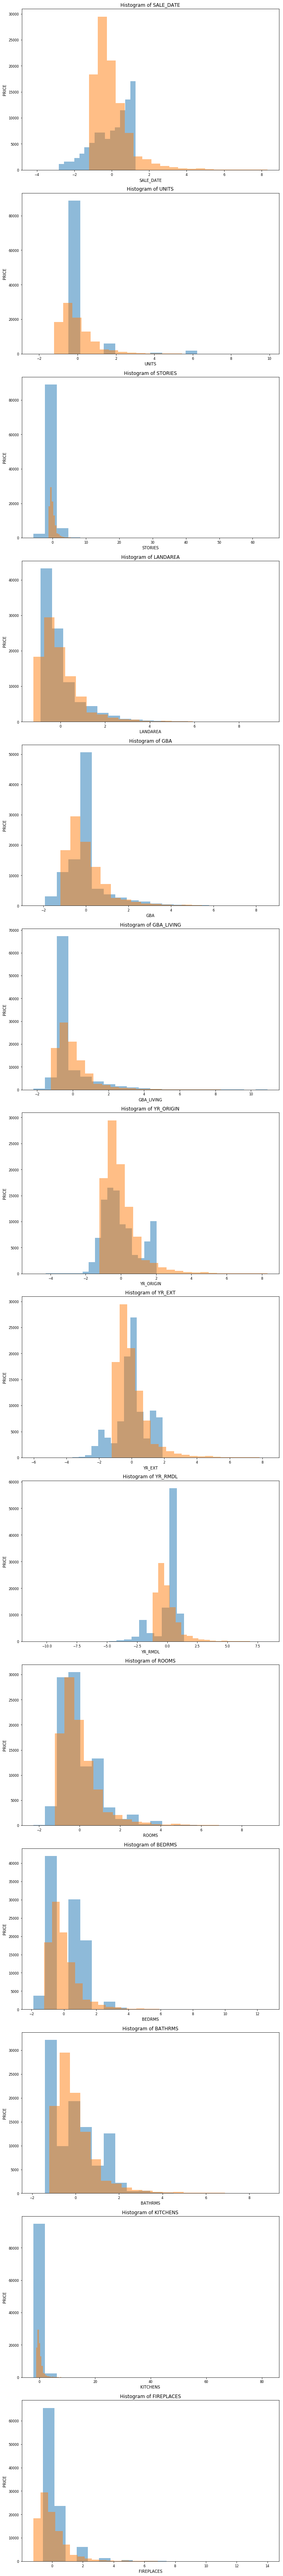

In [4]:
# CHECKING DISTRIBUTIONS

# it does not appear that the variables would benefit from transformations.

def hist_all(df, target):
    #scaling numerical cols
    num_list = list(df.loc[:, (df.dtypes == np.float64)].columns)
    scaledf = pd.DataFrame()
    for col in num_list:
        scaledf[col] = (df[col] - np.mean(df[col])) / np.std(df[col])
    num_list.remove(target)
    
    #histograms for numerical facets
    fig, axs = plt.subplots(len(scaledf.columns)-3,1, figsize=(10,6*len(scaledf.columns)))
    plt.rc('xtick', labelsize='small') 
    plt.rc('ytick', labelsize='small') 
    for i, name in enumerate(num_list):
        if (str(name) != target):
            plt.subplot(len(num_list), 1, i+1)
            a = plt.hist(scaledf[name], alpha=.5, bins=20)
            a = plt.hist(scaledf[target], alpha=.5, bins=20)
            plt.xlabel(name)
            plt.ylabel(target)
            plt.title("Histogram of %s" % name)  
    plt.tight_layout()

hist_all(dropdf, 'PRICE')

In [5]:
# CORRELATION MATRIX

num_df = dropdf.loc[:, (dropdf.dtypes == np.float64)]
num_df.drop('PRICE', axis=1)
num_df.corr()

,PRICE,SALE_DATE,UNITS,STORIES,LANDAREA,GBA,GBA_LIVING,YR_ORIGIN,YR_EXT,YR_RMDL,ROOMS,BEDRMS,BATHRMS,KITCHENS,FIREPLACES
PRICE,1.000000,0.340855,0.039034,0.194127,0.285163,0.495503,0.209558,-0.052633,0.224067,0.131332,0.341580,0.368075,0.544734,0.071272,0.457010
SALE_DATE,0.340855,1.000000,-0.043928,0.000099,-0.117953,-0.030799,0.070168,0.091015,0.090148,0.181134,-0.088136,-0.055117,0.051947,-0.027365,-0.075685
UNITS,0.039034,-0.043928,1.000000,0.136183,0.075532,0.328363,-0.075004,-0.146008,-0.017365,0.028958,0.515133,0.365530,0.361999,0.917370,0.032110
STORIES,0.194127,0.000099,0.136183,1.000000,-0.098306,0.285626,-0.033762,-0.025822,0.117069,0.000285,0.188263,0.176294,0.226098,0.132691,0.160580
LANDAREA,0.285163,-0.117953,0.075532,-0.098306,1.000000,0.423964,-0.125509,-0.102294,0.118530,0.131647,0.561875,0.570182,0.498593,0.089457,0.417155
GBA,0.495503,-0.030799,0.328363,0.285626,0.423964,1.000000,-0.017845,0.005036,0.134347,-0.011136,0.487799,0.432428,0.582730,0.327427,0.430722
GBA_LIVING,0.209558,0.070168,-0.075004,-0.033762,-0.125509,-0.017845,1.000000,0.191063,0.030041,0.035651,-0.048596,0.006832,0.098684,-0.079702,-0.024699
YR_ORIGIN,-0.052633,0.091015,-0.146008,-0.025822,-0.102294,0.005036,0.191063,1.000000,0.687240,0.123334,-0.225343,-0.247055,-0.074426,-0.154518,-0.197663
YR_EXT,0.224067,0.090148,-0.017365,0.117069,0.118530,0.134347,0.030041,0.687240,1.000000,0.293536,0.159569,0.167422,0.275745,-0.005713,0.067424
YR_RMDL,0.131332,0.181134,0.028958,0.000285,0.131647,-0.011136,0.035651,0.123334,0.293536,1.000000,0.186536,0.233489,0.219189,0.040200,-0.023505


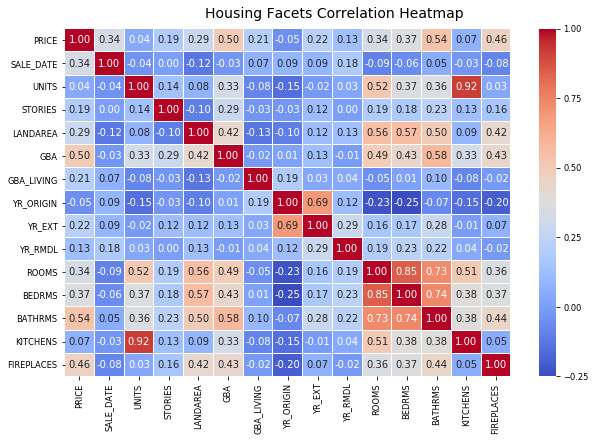

In [6]:
# HEATMAP

f, ax = plt.subplots(figsize=(10, 6))
corr = num_df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Housing Facets Correlation Heatmap', fontsize=14)

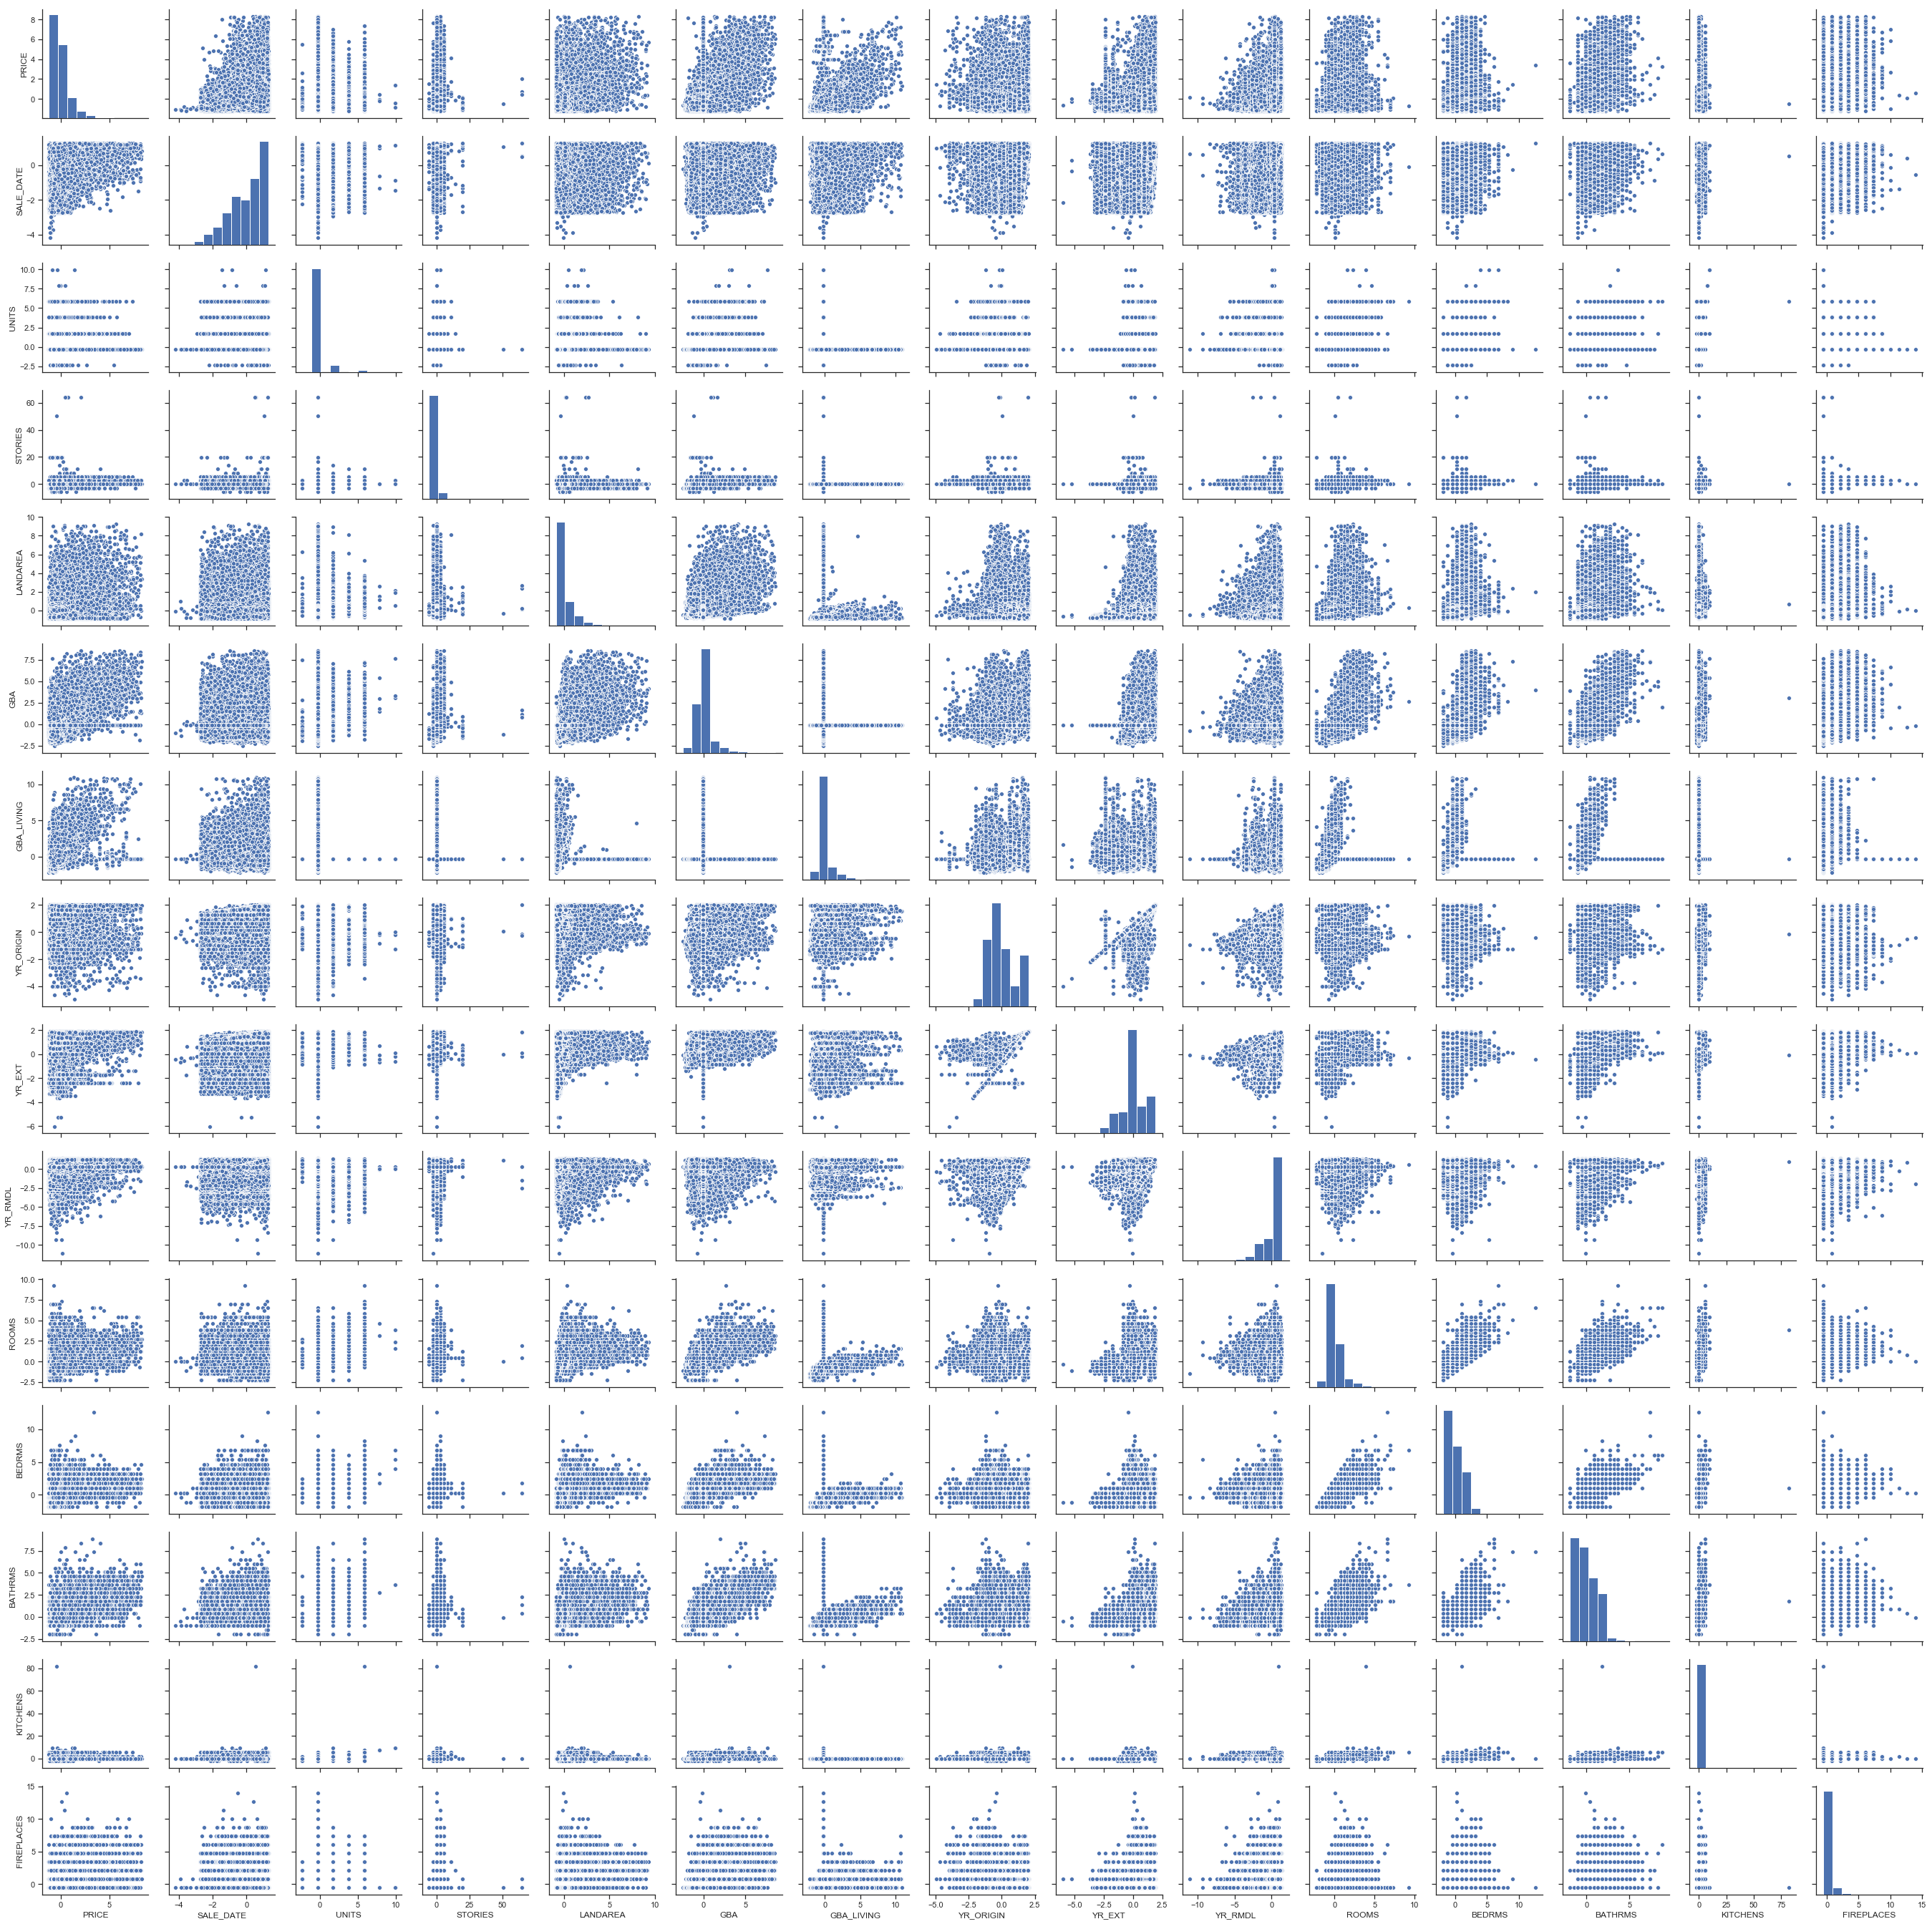

In [7]:
# scatterplots of numerical columns
num_list = list(dropdf.loc[:, (dropdf.dtypes == np.float64)].columns)
scaledf = pd.DataFrame()
for col in dropdf[num_list]:
    scaledf[col] = (dropdf[col] - np.mean(dropdf[col])) / np.std(dropdf[col])
        
sns.set(style="ticks")
sns.pairplot(scaledf)

## FEATURE SELECTION:

#### Potential variables to drop: 
* ##### kitchens/units
* ##### room/bedroom  <br>   

* kitchen and units .917
* bedrooms and room .845
* bathrooms and bedrooms .735
* bathrooms and rooms .729
* yr_origin and yr_ext .687
* bathrooms and GBA .577
* bedrooms and landarea .570
* rooms and landarea .561
* *units and room .515
* *kitchens and room .514

In [8]:
# CENSUS_BLOCK and SQUARE are the most specific geographical facets. 

geo_facets = ['QUADRANT', 'WARD', 'NBHD', 'SUBNBHD', 'CENSUS_BLOCK', 'ZIPCODE', 'SQUARE']
for facet in geo_facets:
    print("The number of unique values in %s IS %f" % (facet, len(finaldf[facet].unique())))

The number of unique values in QUADRANT IS 4.000000
The number of unique values in WARD IS 8.000000
The number of unique values in NBHD IS 56.000000
The number of unique values in SUBNBHD IS 122.000000
The number of unique values in CENSUS_BLOCK IS 3763.000000
The number of unique values in ZIPCODE IS 24.000000
The number of unique values in SQUARE IS 3231.000000


## SCALING FOR REGRESSION:

In [9]:
#scale numerical X variables
X_cols = dropdf.drop('PRICE', axis=1)

num_list = list(dropdf.loc[:, (dropdf.dtypes == np.float64)].columns)
num_list.remove('PRICE')

scaler = StandardScaler()
X_scaled = X_cols.copy()
X_scaled[num_list] = scaler.fit_transform(X_cols[num_list])

# create dummy variables
Xdum = pd.get_dummies(X_scaled, drop_first=True)

# dataframe for regression: regdf
regdf = Xdum.copy()
regdf['PRICE'] = dropdf['PRICE']

In [10]:
print("The size of our frame without dummies is {}".format(finaldf.shape))
print("The size of our regression df is {}".format(regdf.shape))

The size of our frame without dummies is (97223, 37)
The size of our regression df is (97223, 7346)


## REGRESSION AND OUTLIER REMOVAL WITH STATSMODELS:

In [ ]:
# regression statsmodels
import statsmodels.api as sm

y = regdf['PRICE']
X = regdf.drop('PRICE', axis=1)

X = sm.add_constant(X)
reg_all = sm.OLS(y, X).fit()
reg_all.summary()

AttributeError: 'LinearRegression' object has no attribute 'get_influence'

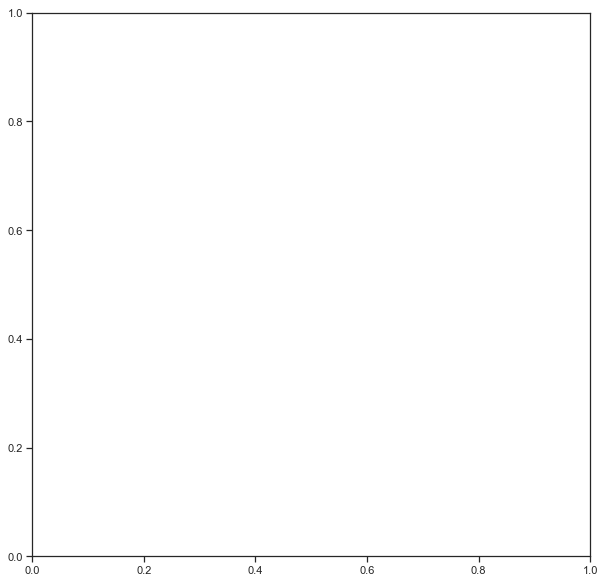

In [20]:
import statsmodels.graphics.regressionplots as plots
# use regression from statsmodels 
fig = plots.influence_plot(reg_all, alpha=0.01, plot_alpha=0.2, fontsize="small")

In [ ]:
plt.hist(m.get_influence().resid_studentized_external)

In [ ]:
# From the plot, it looks like H leverage > 0.05 are points I want to remove. Note that 0.05 has nothing to do with
# alpha, this is just a coincidence.

high_leverage_points = np.where(m.get_influence().hat_matrix_diag > 0.05)

# Based on the histogram of the studentized residuals, I'll also remove any residuals that are greater than 3.
# Because the residuals are standardized, they are on the same scale as z-scores.

high_studentized_resid = np.where(m.get_influence().resid_studentized_external > 3)

remove = np.concatenate([high_leverage_points[0], high_studentized_resid[0]])

regdf_no_outliers = regdf.drop(remove)
print regdf.shape, regdf_no_outliers.shape

# run regression again

## TESTING MODELS AND REGULARIZATION WITH SKLEARN:

In [17]:
# regression with scikitlearn:
X = regdf.drop('PRICE', axis=1).values
y = regdf['PRICE'].values

reg_basic=LinearRegression()
reg_basic.fit(X, y)
print("R^2")
print(reg_basic.score(X, y))

R^2
0.817880014714489


In [15]:
# linear regression function
X = regdf.drop('PRICE', axis=1).values
y = regdf['PRICE'].values

def linreg(X, y): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    reg_all=LinearRegression()
    reg_all.fit(X_train, y_train)
    y_pred = reg_all.predict(X_test)
    print("R^2: {}".format(reg_all.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error: {}".format(rmse))
    
linreg(X, y)

R^2: -5844088135337245.0
Root Mean Squared Error: 31476777678315.79


In [ ]:
# ridge regression function
def ridgereg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    space = np.linspace(0, 1, 10)
    param_grid = {'alpha': space}
    
    ridge = Ridge()
    gm_cv = GridSearchCV(ridge, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned Ridge alpha: {}".format(gm_cv.best_params_))
    print("Tuned Ridge R squared: {}".format(r2))
    print("Tuned Ridge MSE: {}".format(mse))

In [ ]:
# lasso regression function
def lassoreg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    space = np.linspace(0, 1, 10)
    param_grid = {'alpha': space}
    
    lasso = Lasso()
    gm_cv = GridSearchCV(lasso, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned LASSO Alpha: {}".format(gm_cv.best_params_))
    print("Tuned LASSO R squared: {}".format(r2))
    print("Tuned LASSO MSE: {}".format(mse))

In [ ]:
#ElasticNet function
def elasticnet(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    space = np.linspace(0, 1, 10)
    param_grid = {'l1_ratio': space}
    
    elastic_net = ElasticNet()
    gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
    print("Tuned ElasticNet R squared: {}".format(r2))
    print("Tuned ElasticNet MSE: {}".format(mse))

# WHAT SPECIFIC METRICS DESCRIBE OVER FITTING?
* compare training with test set. if model works significantly better on training set (R^2. MSE?), then it's overfitting. 

* "Regularization" process (correcting over fitting):
    * 1. check for outliers
    * 2. remove features
    * 3. try ridge lasso elasticnet
    * 4. go to other methods. 

def ridgereg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    space = np.linspace(0, 1, 10)
    param_grid = {'alpha': space}
    
    ridge = Ridge()
    gm_cv = GridSearchCV(ridge, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned Ridge alpha: {}".format(gm_cv.best_params_))
    print("Tuned Ridge R squared: {}".format(r2))
    print("Tuned Ridge MSE: {}".format(mse))
    
    
def lassoreg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    space = np.linspace(0, 1, 10)
    param_grid = {'alpha': space}
    
    lasso = Lasso()
    gm_cv = GridSearchCV(lasso, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned LASSO Alpha: {}".format(gm_cv.best_params_))
    print("Tuned LASSO R squared: {}".format(r2))
    print("Tuned LASSO MSE: {}".format(mse))
    
    
def elasticnet(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    space = np.linspace(0, 1, 10)
    param_grid = {'l1_ratio': space}
    
    elastic_net = ElasticNet()
    gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
    print("Tuned ElasticNet R squared: {}".format(r2))
    print("Tuned ElasticNet MSE: {}".format(mse))
    
    
    
    
    
    
